In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Storytelling

First I will read in the data and convert to the correct data types.

In [2]:
loans = pd.read_csv('loans_clean.csv')

In [3]:
loans.shape

(160815, 72)

In [4]:
pd.options.display.max_rows = 150

In [5]:
dtypes = loans.dtypes
object_vars = list(dtypes[dtypes == 'object'].index)

In [6]:
loans[object_vars] = loans[object_vars].astype('category')

In [7]:
date_vars = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d']

In [8]:
loans.loc[:, date_vars] = loans.loc[:, date_vars].apply(pd.to_datetime, errors='coerce')

#### ROI and Grade

The amount to be paid back on a loan should be strongly correlated with the original loan amount.

I'll create a scatterplot of the funded amoun't versus the amount repaid. The high number of obeservations result in full saturation even with a very low alpha, hiding a lot of nuances. To get around this, I'll create a random sample of observations to pass to the plot.


In [9]:
loans_sample = loans.sample(frac=0.05)

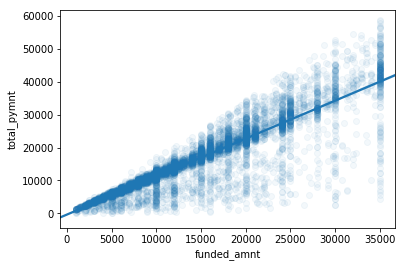

In [10]:
sns.regplot(x = 'funded_amnt', y='total_pymnt', data=loans_sample, scatter_kws={'alpha':0.05})

Plotting the funded amount against the amount paid back for each loan shows the strong linear relationship expected. Across the range of funded amounts, the amount that should be repaid will be the funded amount plus interest.  There is a linear zone of higher density that represents the loans that were paid back as expected. There is spread within this higher-denisty area due to varying interest rates (which is unfortunate for the person who borrowed \$35,000 and repaid nearly \$60,000 with interest, but fortunate for the investor). The points below the diagonal higher-density zone represent the loans that defaulted and were not repaid in full.


Since funded amount is such a strong predictor of total payment, it may overwhelm other variables.

For example, if I want to see the amount repaid by grade, will the differences between grades be do to the performance of loans of that grade, or due to the size of loans in that grade?  The grade is assigned by Lending club based on how risky the loan is, ranging from A through F.

In [11]:
loans['grade'] = loans['grade'].cat.as_ordered()

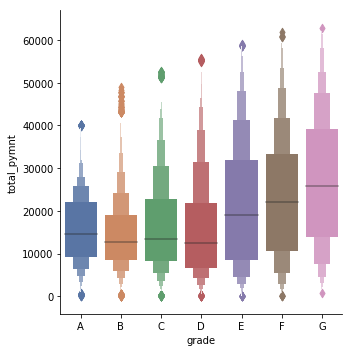

In [12]:
sns.catplot(x ='grade', y='total_pymnt', kind = 'boxen', data = loans, palette="deep")

Looking at the amount repaid by grade, it looks like the G-grade loans pay back the most. Since G is the lowest grade, I expect that the only thing that could account for the high repayment amount is a high initial loan amount.

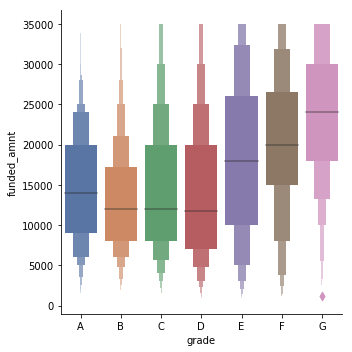

In [13]:
sns.catplot(x = 'grade', y='funded_amnt', kind = 'boxen', data=loans, palette="deep")

Looking at the funded amount by grade confirms that the G-grade loans indeed have the highest median loan amount of about \$25,000.

This suggests that the amount requested affects the assigned grade, rather than a pre-determined grade affecting how much an applicant is allowed to borrow.

This still doesnt do a very good job of showing how well a loan performs compared to how it is expected to perform based on the original amount funded.  To achieve this, I will create an ROI variable, which is the difference between the amount repaid and the amount borrowed divided by the amount borrowed.  The ROI would be zero if the borrower paid back exactly what they borrowed, and negative if they repay less than they originally borrowed. The expected ROI would be above zero to reflect the interest paid.

In [14]:
loans['roi'] = (loans['total_pymnt'] - loans['funded_amnt']) / loans['funded_amnt']

Now I can plot the ROI by grade instead of the amount repaid by grade, and display some summary statistics.

I would expect the interest rates to be lowest for Grade A and highest for Grade F, which means that lower-graded loans would have higher ROIs if they were paid back in full.  The lower-graded loans are also expected to have higher rates of default bringing the ROI down.  I would expect that the higher interest rates on the lower-grade, riskier loans should at least make up for, on average, the losses due to default, otherwise there wouln't be a reason for investors to lend money on the riskier loans.

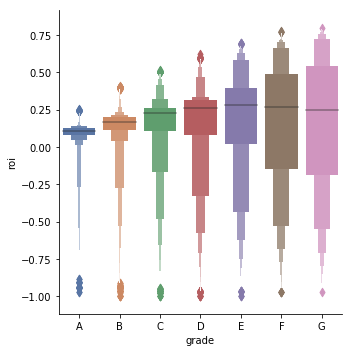

In [15]:
sns.catplot(x = 'grade', y='roi', kind = 'boxen', data=loans, palette="deep")

In [16]:
loans.groupby('grade').describe().loc[:,'roi']

,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
A,22898.0,0.080302,0.127573,-0.969296,0.082122,0.105330,0.126446,0.250578
B,54304.0,0.111082,0.192721,-1.000000,0.111722,0.164930,0.197775,0.404679
C,43490.0,0.132231,0.271775,-1.000000,0.106055,0.224805,0.262098,0.514108
D,24070.0,0.134103,0.320290,-1.000000,0.079741,0.260483,0.312970,0.621157
E,10285.0,0.160348,0.393735,-1.000000,0.018708,0.283976,0.396238,0.697483
F,4838.0,0.151718,0.452428,-0.971648,-0.148290,0.267140,0.490992,0.777588
G,930.0,0.152561,0.478279,-0.970178,-0.185680,0.245302,0.541486,0.797873


Looking at the ROI by grade is much more interesting than just the amount repaid by grade since it removes the affects of loan size.

The least-risky A-grade loans have the lowest median ROI of around 10%, with a mean of 8%.

Grade E loans have the highest mean ROI of 16.0% and highest median ROI of 28.4%, meaning that on average, E loans will give investors the highest returns.  This demonstrates that the higher interest rates on the lower-graded loans more than makes up for the losses due to default through grade E. Past grade E, the defaults start eating more into the additional profits made from the higher interest rates.

Another major consideration is the standard deviations, which is lowest for the Grade A loans at 12.8% and highest for Grade G at 47.8 %. This is an affect of the higher risk of the lower grade loans.  The 25th percentile of the G-Grade loans is -18.4%, meaning 25% of the loans lose at least 18%, even though they have the potential for the highest ROI.

#### Interest Rate

Interest rate is expected to be highly correlated with grade.

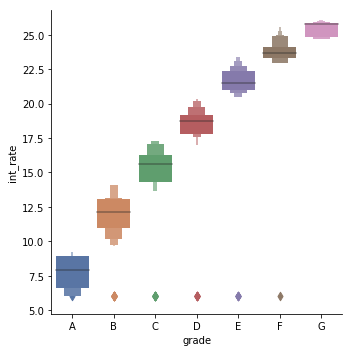

In [17]:
sns.catplot(x = 'grade', y='int_rate', kind = 'boxen', data=loans, palette="deep")

The increase between grades is pretty linear through grade E, however, the increases between grade E and F and between  grade F and G are smaller.  Grades F and G are also the grades where the marginal gain in ROI due to increase in interest rate is no longer outpacing the marginal losses due to increased defaulting, resulting in a lower mean ROI. This might be due to an upper limit to the amount of interest a borrower is willing to pay, which could also account for the lower number of loans in these categories.

Also, there are apparent interest rate gaps between grades, which I will investigate further with a histogram.

In [18]:
bins = []
for i in range(int(min(loans.int_rate)*4), int(max(loans.int_rate)*4)+5, 1):
    bins.append(i/4)

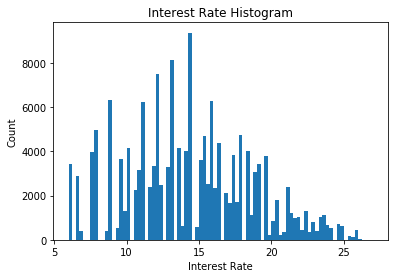

In [19]:
plt.hist(loans.int_rate, bins = bins)
plt.title('Interest Rate Histogram')
plt.xlabel('Interest Rate')
plt.ylabel('Count')
plt.show()


Plotting a histogram with 0.25% intervals, there are some gaps, suggesting that the interest rate has some grouping rather than being fully continious.  This could indicate that there are some borrowers who are grouped in the next higher interest rate, resulting in slightly more profitable loans.

#### Employment Length

Employment length is the length, in years, a borrower has been with their employer.  The original data groups anything over 10-years as "10+ years, so this was left as a categorical variable. Borrowers who are not employed are represented by "none".

I'll convert employment length into an ordered categorical variable for plotting so that the number of years appear in a logical order.

I would expect longer employment length to represent lower risk of default, which may result in lower ROI since lower risk equates to lower interest rates.

In [20]:
loans.emp_length.dtypes

CategoricalDtype(categories=['1 year', '10+ years', '2 years', '3 years', '4 years',
                  '5 years', '6 years', '7 years', '8 years', '9 years',
                  '< 1 year', 'none'],
                 ordered=False)

In [21]:
loans['emp_length'] = loans['emp_length'].cat.reorder_categories(
    ['none', '< 1 year', '1 year', '2 years', '3 years', '4 years',
    '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'], ordered = True)

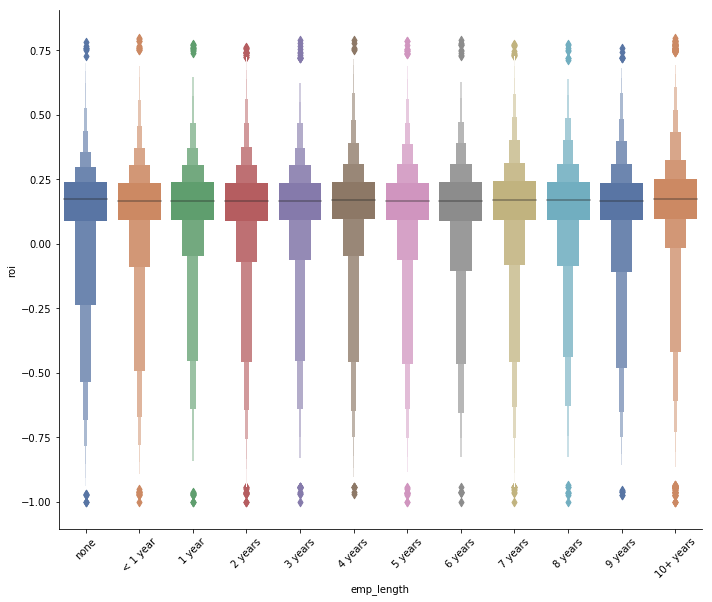

In [22]:
g = sns.catplot(x = 'emp_length', y='roi', kind = 'boxen', data=loans, palette="deep", height=8, aspect=10/8)
g.set_xticklabels(rotation=45)

In [23]:
loans.groupby('emp_length').describe().loc[:,'roi']

,count,mean,std,min,25%,50%,75%,max
emp_length,,,,,,,,
none,6954.0,0.098114,0.279731,-1.000000,0.088208,0.172455,0.237474,0.782442
< 1 year,10987.0,0.110767,0.266688,-1.000000,0.090633,0.164325,0.236165,0.797873
1 year,9629.0,0.117904,0.259092,-1.000000,0.093006,0.166354,0.237848,0.773937
2 years,13683.0,0.115074,0.258847,-1.000000,0.088239,0.164319,0.236169,0.760990
3 years,11950.0,0.116286,0.257242,-1.000000,0.093243,0.165112,0.236169,0.791044
4 years,8779.0,0.120278,0.260864,-0.970713,0.094464,0.171303,0.240982,0.788794
5 years,11992.0,0.117629,0.260036,-1.000000,0.092716,0.166276,0.236852,0.787328
6 years,10042.0,0.114838,0.262949,-1.000000,0.088233,0.164325,0.238035,0.790582
7 years,9668.0,0.119168,0.262621,-1.000000,0.091905,0.168495,0.241440,0.775055


The effect of employment lenghth on ROI is smaller than I would expect.  The median ROI ranges from 16.4% to 17.2%. The interest rates appear to do a good job of making up for the risk associated with shorter employment lengths, which may be an indicator that  this is an important variable used to calculate the grade/interest rates.

Borrowers that are not employed have the highest median ROI at 17.25%, but the lowest mean ROI of 9.81%

#### Home Ownership

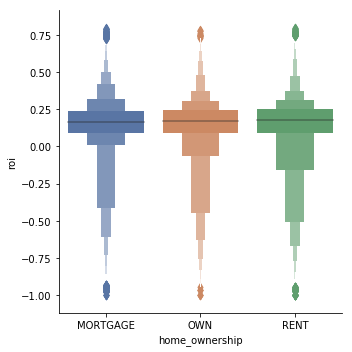

In [24]:
sns.catplot(x = 'home_ownership', y='roi', kind = 'boxen', data=loans, palette="deep")

In [25]:
loans.groupby('home_ownership').describe().loc[:,'roi']

,count,mean,std,min,25%,50%,75%,max
home_ownership,,,,,,,,
MORTGAGE,84430.0,0.125389,0.250909,-1.0,0.092995,0.161448,0.236165,0.796708
OWN,13282.0,0.120465,0.257693,-1.0,0.092675,0.172550,0.242853,0.782442
RENT,63103.0,0.113910,0.274075,-1.0,0.092714,0.178423,0.250640,0.797873


The difference between ownership classes is smaller than expected. Mortgage has the highest ROI and Rent has the lowest, with Owner in the middle.  As with employment length, I suspect this is a strong predictor of the grade/interest rate assigned to the loan, which equalizes the difference between classes.

In [26]:
loans.groupby('home_ownership').describe().loc[:,'int_rate']

,count,mean,std,min,25%,50%,75%,max
home_ownership,,,,,,,,
MORTGAGE,84430.0,13.821571,4.452918,6.0,10.64,13.67,16.78,26.06
OWN,13282.0,14.535784,4.389955,6.0,11.14,14.33,17.57,26.06
RENT,63103.0,15.056618,4.255148,6.0,12.12,15.10,17.77,26.06


Renters have the highest interest rate mean of 15%, and the lowers mean ROI of 11.3%, meaning renters have higher rates of default that is mostly offset by the higher interest.

Borrowers who are mortgaging their home have the lowest mean interest rates yet the highest mean ROI, indicating the lowest defaults.

Surprisingly, Owners are in-between on interest rate and default rates.  Initially I would suspect owners to have the least risk since they don't have a mortgage or rent obligations, but perhaps this is because they are more likely to be retired and their income is lower.

In [27]:
# creating dataframe with no outliers
loans_2 = loans.query('annual_inc < 200000')

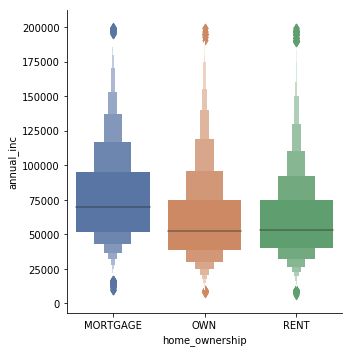

In [28]:
sns.catplot(x = 'home_ownership', y='annual_inc', kind = 'boxen', data=loans_2, palette="deep")

Borrowers who own their home have an annual income similar to those who rent, with a median of approximately \$50,000.

#### Purpose

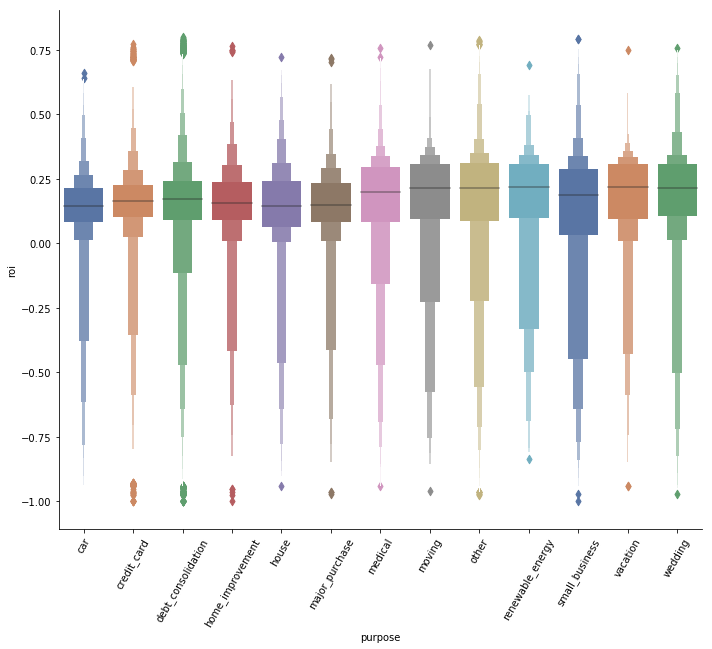

In [29]:
purpose = sns.catplot(x = 'purpose', y='roi', kind = 'boxen', data=loans, palette="deep", height=8, aspect=10/8)
purpose.set_xticklabels(rotation=60)

In [30]:
loans.groupby('purpose').describe().loc[:,'roi']

,count,mean,std,min,25%,50%,75%,max
purpose,,,,,,,,
car,1432.0,0.104538,0.232690,-0.942500,0.080479,0.143110,0.214869,0.659354
credit_card,37833.0,0.124161,0.231724,-1.000000,0.099507,0.163285,0.226375,0.773784
debt_consolidation,96278.0,0.119070,0.266831,-1.000000,0.090190,0.169645,0.241262,0.797873
home_improvement,8641.0,0.118304,0.248157,-1.000000,0.087874,0.156722,0.235634,0.764703
house,843.0,0.108000,0.260431,-0.942499,0.063104,0.145029,0.241692,0.721366
major_purchase,2900.0,0.110942,0.249184,-0.971446,0.081132,0.149493,0.231962,0.716649
medical,1218.0,0.127446,0.279159,-0.943325,0.081874,0.197156,0.295056,0.755971
moving,827.0,0.124636,0.303407,-0.961565,0.093730,0.212066,0.306593,0.769476
other,7214.0,0.132869,0.306135,-0.975554,0.084052,0.214888,0.310337,0.787328


The ROI by purchase can be broadly put into two groups.  Loans for cars, credit cards, debt consolidation, home improvement, and house have lower ROIs, but are less risky as they have lower standard deviations.

Loans for medical, moving, other,  renewable energy, vacation, and weddings tend to have better ROIs than the first group, bit also more risk of default with higher standard deviations.

Small business loans are the one category that is hard to put into these two groups, as it has the lower median ROI of the first group, and the higher risk associated with the second group.  It also has both the lowest mean ROi and the highest standard deviation, making it, on average, the worst loan purpose to invest in.

#### Debt to Income

Higher debt to income ratio is associated with a higher risk of default. I assume higher DTI results in a lower grade and a higher interest rate, but am curious to see if the higher interest rate makes up for the increased risk.

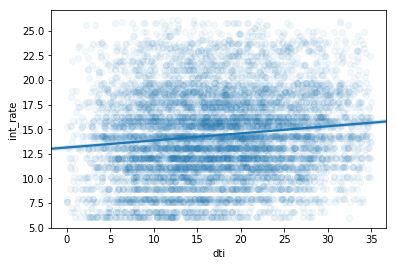

In [31]:
loans_sample = loans.sample(frac=0.05)
sns.regplot(x = 'dti', y='int_rate', data=loans_sample, scatter_kws={'alpha':0.05})

There is a positive association between higher DTI and higher interest rates, but there are many other variables affecting interest rate, resulting in a lot of variance.

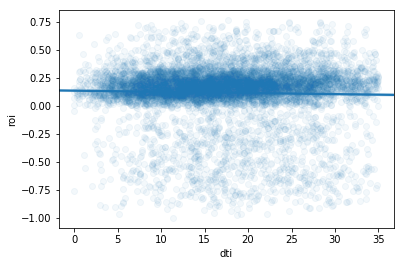

In [32]:
p = sns.regplot(x = 'dti', y='roi', data=loans_sample, scatter_kws={'alpha':0.05})

The relationship between DTI and ROI is pretty weak, but slightly negative.  This suggests that the inceased interest rates for borrowers with a high DTI ratio might not be as high as they should be.

#### Revolving Debt Utilization

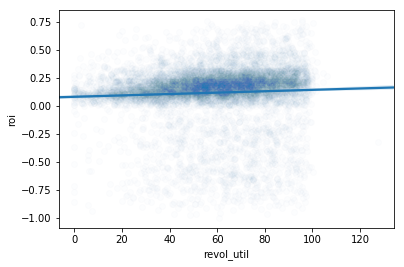

In [33]:
sns.regplot(x = 'revol_util', y='roi', data=loans_sample, scatter_kws={'alpha':0.01})

Higher degrees of revolving debt utilization is associated with higher risk. There is a positive linear relationship between revolving debt untilization and ROI, meaning that the higher risk of defaults associated with high revolving debt utilization is more than offset by higher interest rates, on average.